In [17]:
%matplotlib inline

In [18]:
import sympy
import numpy as np
import library.DualEKF as DEKF

x1, x2, x3, w1, w2, w3, u1, u2, u3, u4 = sympy.symbols('x1 x2 x3 w1 w2 w3 u1 u2 u3 u4')
state = sympy.Matrix([x1, x2, x3])
parameters = sympy.Matrix([w1, w2, w3])
inputs = sympy.Matrix([u1, u2, u3, u4])
fun = sympy.Matrix([x1 - w1*x1 + u1*w1 - x1*u3*w2 + u2*u3*w2 + u4*w3, u1, u2])
measure = np.matrix([[1.0, 0, 0],[0.0, 0, 0],[0.0, 0, 0]])

In [19]:
import pandas as pd
data = pd.read_csv('data/EP_CO2.csv')
state_estimates = np.matrix([[data["ZoneCO2"][0]], [420.0], [0.01]])
parameter_etsimates = np.matrix([[0.08],
                             [5.0],
                             [30.3]])
Px = np.eye(3)
tolerance = np.matrix([[10],[0],[0]])

In [20]:
dekf = DEKF.DualExtendedKalmanFilter(fun, state, parameters, inputs, measure, state_estimates, parameter_etsimates,
                                    forget=1, P_x=Px, tolerance=tolerance)

In [21]:
U1 = 420
U2 = data["SupplyCO2"][0]
U3 = data["SupplyFlow"][0]
U4 = data["OCCU"][0]

In [22]:
controls = np.matrix([[U1],[U2],[U3],[U4]])

In [32]:
dekf.Predict(controls)
print(dekf.C)
print(dekf.X_values)

[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[ 419.71022893]
 [ 420.        ]
 [ 414.15280768]]


In [33]:
x1_meas = data["ZoneCO2"][1]
new_measurements = np.matrix([[x1_meas], [0.0], [0.0]])
#print(new_measurements)
dekf.Update(new_measurements)
print(dekf.C*dekf.Px*dekf.C.T)

[[ 0.00099999  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [34]:
length = data.shape[0]
iterations = length
np.random.seed(1234)
zoneCO2_noise = np.random.normal(0,8,iterations)
supplyCO2_noise = np.random.normal(0,8,iterations)
supplyflow_noise = np.random.normal(0,0.001,iterations)

In [35]:
predicted = []
actual = []
measured = []
p1 = []
p2 = []
p3 = []
for i in range(1, iterations):
    #generate control vector
    C_out = 420
    C_supply = data["SupplyCO2"][i-1] + supplyCO2_noise[i-1]
    Q_supply = data["SupplyFlow"][i-1] + supplyflow_noise[i-1]
    OCC = data["OCCU"][i-1]
    controls = np.matrix([[C_out], [C_supply], [Q_supply], [OCC]])

    #prediction
    dekf.Predict(controls)
    predicted.append(dekf.X_values[0,0])
    p1.append(dekf.W_values[0,0])
    p2.append(dekf.W_values[1,0])
    p3.append(dekf.W_values[2,0])

    #update
    meas = data["ZoneCO2"][i] + zoneCO2_noise[i]
    actual.append(data["ZoneCO2"][i])
    measured.append(meas)
    dekf.Update(np.matrix([[meas],[0],[0]]))

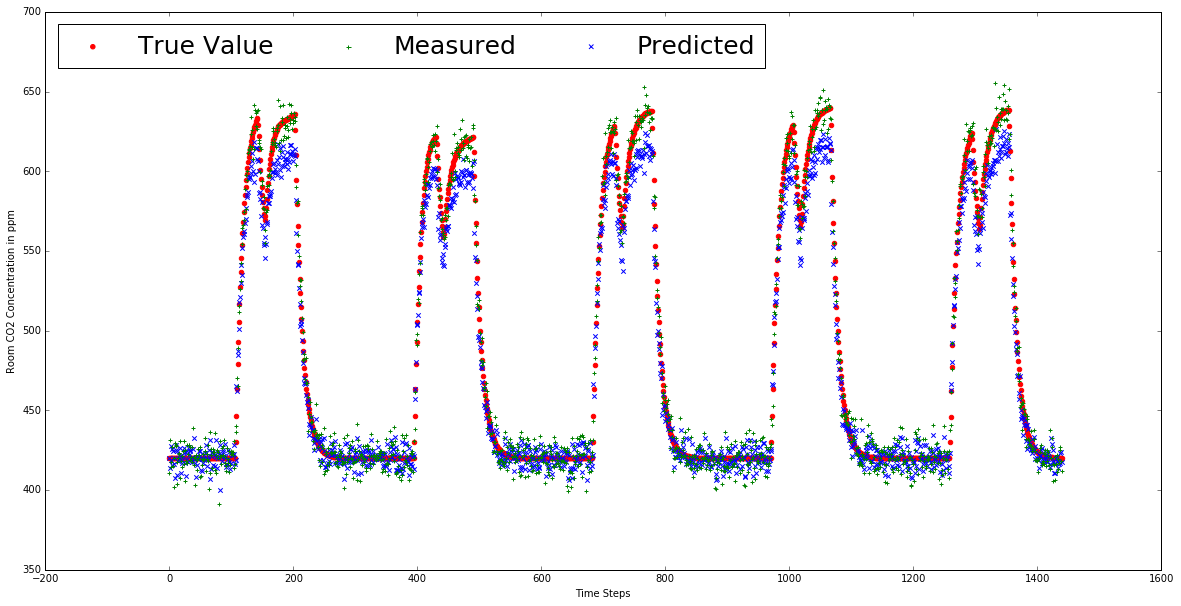

In [36]:
import matplotlib.pyplot as plt
#plotting first three days of prediction results
plot_len = (5*24*12)
x = np.arange(plot_len)
plt.figure(figsize=(20,10))
tru = plt.scatter(x, actual[0:plot_len], color="r", marker="o")
pre = plt.scatter(x, predicted[0:plot_len], color="b", marker="x")
mea = plt.scatter(x, measured[0:plot_len], color="g", marker = "+")
plt.legend((tru,mea,pre),
           ("True Value","Measured","Predicted"),
            scatterpoints = 1,
            ncol = 3,
            fontsize=25,
            loc="upper left")
plt.xlabel("Time Steps")
plt.ylabel("Room CO2 Concentration in ppm")
plt.show()

In [37]:
print(dekf.W_values)

[[  0.24509712]
 [  5.16509712]
 [ 30.46509712]]


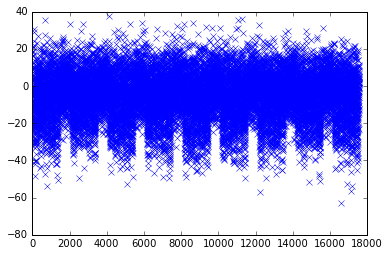

In [38]:
import operator
residues = list(map(operator.sub, predicted, measured))
plt.plot(residues, 'x')
plt.show()

In [30]:
#after first 15 days of waiting for the data to stabilize, 
#use the rest of the 15 days to obtain normal operation parameters
normal_start = 15*24*12
normal_end = 30*24*12
p1_normal = p1[normal_start:normal_end]
p2_normal = p2[normal_start:normal_end]
p3_normal = p3[normal_start:normal_end]

In [31]:
print('P1 ideal value is 0.083, estimated average is {0} and std is {1} '.format(np.mean(p1_normal),np.std(p1_normal)))
print('P2 ideal value is 4.867, estimated average is {0} and std is {1} '.format(np.mean(p2_normal),np.std(p2_normal)))
print('P2 ideal value is 29.917, estimated average is {0} and std is {1} '.format(np.mean(p3_normal),np.std(p3_normal)))

P1 ideal value is 0.083, estimated average is 0.2166675460063616 and std is 0.0033122253009794634 
P2 ideal value is 4.867, estimated average is 5.136667546006356 and std is 0.003312225300976203 
P2 ideal value is 29.917, estimated average is 30.43666754600637 and std is 0.0033122253009777195 
